<a href="https://colab.research.google.com/github/DebuggingaHopper/Drone/blob/main/Capitol_Drone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The following Model conducts is binary label classification**

This was the original approach however after looking at the JSOn file there was a noticable amount of labels not taken into account

In [92]:
import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from PIL import Image

# Load JSON data
with open('result.json', 'r') as json_file:
    data = json.load(json_file)

# Prepare data

labels = []  # Bounding box coordinates
image_paths = []
for item in data:
    if "completions" in item and len(item["completions"]) > 0:
        completion = item["completions"][0]
        if "result" in completion and len(completion["result"]) > 0:
            result = completion["result"][0]
            if "value" in result and "rectanglelabels" in result["value"]:
                labels.append(result["value"]["rectanglelabels"])
                image_path = item["data"]["image"]
                image_path = image_path.split('-', 1)[-1]
                image_paths.append(image_path)

# Load and preprocess images
images = [np.array(Image.open(image_path).resize((341, 192))) for image_path in image_paths]  # Adjust dimensions as needed

In [93]:
print(labels)

[['Fhouse'], ['Parkinglot'], ['boat'], ['Fhouse'], ['Parkinglot'], ['boat'], ['boat'], ['Lampost'], ['boat'], ['Lampost'], ['Parkinglot'], ['Lampost'], ['boat'], ['Fhouse'], ['Fhouse']]


In [94]:
print(len(labels))

15


In [95]:
print(images)

[array([[[111,  93,  72],
        [109,  90,  74],
        [109,  90,  76],
        ...,
        [227, 219, 140],
        [230, 223, 143],
        [232, 226, 143]],

       [[110,  92,  69],
        [ 94,  76,  58],
        [102,  84,  70],
        ...,
        [229, 222, 144],
        [232, 225, 145],
        [234, 228, 146]],

       [[ 95,  77,  58],
        [ 96,  79,  63],
        [ 81,  66,  55],
        ...,
        [236, 228, 150],
        [238, 231, 153],
        [241, 234, 154]],

       ...,

       [[ 94, 105, 125],
        [ 81,  92, 113],
        [ 81,  92, 115],
        ...,
        [ 87,  87, 102],
        [ 87,  91, 106],
        [ 87,  93, 109]],

       [[ 94, 105, 125],
        [ 81,  92, 113],
        [ 98, 109, 131],
        ...,
        [ 82,  84,  98],
        [ 83,  89, 104],
        [ 83,  91, 107]],

       [[ 94, 105, 125],
        [ 89, 100, 122],
        [ 97, 108, 130],
        ...,
        [ 78,  83,  97],
        [ 77,  84,  99],
        [ 78,  86, 102]

In [96]:
print(len(image_paths))

15


In [97]:
# Convert labels to one-hot encoding
label_set = list(set(label for sublist in labels for label in sublist))
label_to_index = {label: idx for idx, label in enumerate(label_set)}
num_classes = len(label_set)

# Convert labels to one-hot encoding
labels_encoded = []
for label_list in labels:
    label_encoded = [0] * num_classes
    for label in label_list:
        label_encoded[label_to_index[label]] = 1
    labels_encoded.append(label_encoded)

# Convert lists to NumPy arrays
images_array = np.array(images)
labels_array = np.array(labels_encoded)


In [98]:
print(images_array)

[[[[111  93  72]
   [109  90  74]
   [109  90  76]
   ...
   [227 219 140]
   [230 223 143]
   [232 226 143]]

  [[110  92  69]
   [ 94  76  58]
   [102  84  70]
   ...
   [229 222 144]
   [232 225 145]
   [234 228 146]]

  [[ 95  77  58]
   [ 96  79  63]
   [ 81  66  55]
   ...
   [236 228 150]
   [238 231 153]
   [241 234 154]]

  ...

  [[ 94 105 125]
   [ 81  92 113]
   [ 81  92 115]
   ...
   [ 87  87 102]
   [ 87  91 106]
   [ 87  93 109]]

  [[ 94 105 125]
   [ 81  92 113]
   [ 98 109 131]
   ...
   [ 82  84  98]
   [ 83  89 104]
   [ 83  91 107]]

  [[ 94 105 125]
   [ 89 100 122]
   [ 97 108 130]
   ...
   [ 78  83  97]
   [ 77  84  99]
   [ 78  86 102]]]


 [[[ 25  29  32]
   [ 27  31  34]
   [ 34  38  41]
   ...
   [ 43  46  55]
   [ 40  43  52]
   [ 43  46  55]]

  [[ 25  29  32]
   [ 29  33  36]
   [ 37  41  44]
   ...
   [ 38  41  50]
   [ 34  37  46]
   [ 38  41  50]]

  [[ 25  29  32]
   [ 27  31  34]
   [ 31  35  38]
   ...
   [ 36  39  48]
   [ 36  39  48]
   [ 35  38

In [99]:
print(labels_array)

[[0 1 0 0]
 [0 0 1 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 0 0 1]
 [1 0 0 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 0 1]
 [1 0 0 0]
 [0 1 0 0]
 [0 1 0 0]]


In [100]:
# Define and compile the model
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(192, 341, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(num_classes, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(images_array, labels_array, epochs=10, batch_size=32)

Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 8.0100 - accuracy: 0.4000
Epoch 2/10
1/1 [==============================] - 1s 634ms/step - loss: 5335.4814 - accuracy: 0.2000
Epoch 3/10
1/1 [==============================] - 1s 592ms/step - loss: 2158.6306 - accuracy: 0.5333
Epoch 4/10
1/1 [==============================] - 1s 839ms/step - loss: 819.0179 - accuracy: 0.6000
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 905.1942 - accuracy: 0.5333
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 1093.9553 - accuracy: 0.4667
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 1260.7273 - accuracy: 0.4667
Epoch 8/10
1/1 [==============================] - 1s 1s/step - loss: 1057.1790 - accuracy: 0.4667
Epoch 9/10
1/1 [==============================] - 1s 872ms/step - loss: 763.3597 - accuracy: 0.5333
Epoch 10/10
1/1 [==============================] - 1s 687ms/step - loss: 635.6604 - accuracy: 0.6667


In [101]:
# Choose a random index from the training dataset
random_index = np.random.randint(0, len(images_array))

# Load and preprocess the random image
random_image = images_array[random_index]
random_image = np.expand_dims(random_image, axis=0)  # Add batch dimension

# Get the actual labels for the random image
actual_labels = labels_array[random_index]

# Run prediction
predictions = model.predict(random_image)

# Threshold predictions (you can adjust the threshold based on your needs)
threshold = 0.5
binary_predictions = (predictions > threshold).astype(np.int)

# Print or use the predictions as needed
print("Actual Labels:", actual_labels)
print("Predictions:", binary_predictions)

# Calculate accuracy
accuracy = np.mean(np.equal(actual_labels, binary_predictions))
print("Accuracy:", accuracy)

1/1 [==============================] - 0s 77ms/step
Actual Labels: [0 1 0 0]
Predictions: [[0 1 0 0]]
Accuracy: 1.0


<ipython-input-101-85b04643d66f>:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  binary_predictions = (predictions > threshold).astype(np.int)


# You will notice that if I run the following the amount of labels are far more than the ones used in the datatset

In [102]:
rectanglelabels_count = 0

for item in data:
    for completion in item.get("completions", []):
        for result in completion.get("result", []):
            if result.get("value", {}).get("rectanglelabels"):
                rectanglelabels_count += 1

print("Number of instances of rectanglelabels:", rectanglelabels_count)

Number of instances of rectanglelabels: 36


# **The following model is to the same but with a different approach to acquire the correct amount of labels present**

In [103]:
import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from PIL import Image

# Load JSON data
with open('result.json', 'r') as json_file:
    data = json.load(json_file)

# Prepare data
labels = []  # Bounding box coordinates
image_paths = []

for item in data:
    if "completions" in item and len(item["completions"]) > 0:
        completion = item["completions"][0]
        if "result" in completion and len(completion["result"]) > 0:
            for result in completion["result"]:
                if "value" in result and "rectanglelabels" in result["value"]:
                    for rectangle_label in result["value"]["rectanglelabels"]:
                        labels.append(result["value"]["rectanglelabels"])
                        image_path = item["data"]["image"]
                        image_path = image_path.split('-', 1)[-1]
                        image_paths.append(image_path)



# Load and preprocess images
images = []
for i, image_path in enumerate(image_paths):
    img = Image.open(image_path).resize((341, 192))
    img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
    images.append(img_array)
    print(image_path)
    print(f"Processed image {i + 1}/{len(image_paths)}")

# Now 'images' and 'labels' contain your image data and bounding box coordinates

DJI_0044.JPG
Processed image 1/36
DJI_0040.JPG
Processed image 2/36
DJI_0040.JPG
Processed image 3/36
DJI_0040.JPG
Processed image 4/36
DJI_0055.JPG
Processed image 5/36
DJI_0045.JPG
Processed image 6/36
DJI_0045.JPG
Processed image 7/36
DJI_0045.JPG
Processed image 8/36
DJI_0045.JPG
Processed image 9/36
DJI_0045.JPG
Processed image 10/36
DJI_0045.JPG
Processed image 11/36
DJI_0058.JPG
Processed image 12/36
DJI_0058.JPG
Processed image 13/36
DJI_0042.JPG
Processed image 14/36
DJI_0041.JPG
Processed image 15/36
DJI_0052.JPG
Processed image 16/36
DJI_0052.JPG
Processed image 17/36
DJI_0052.JPG
Processed image 18/36
DJI_0043.JPG
Processed image 19/36
DJI_0051.JPG
Processed image 20/36
DJI_0051.JPG
Processed image 21/36
DJI_0051.JPG
Processed image 22/36
DJI_0051.JPG
Processed image 23/36
DJI_0046.JPG
Processed image 24/36
DJI_0046.JPG
Processed image 25/36
DJI_0039.JPG
Processed image 26/36
DJI_0039.JPG
Processed image 27/36
DJI_0039.JPG
Processed image 28/36
DJI_0039.JPG
Processed image 

In [104]:
print(len(labels))

36


In [105]:
print(len(images))

36


In [106]:
# Convert labels to one-hot encoding
label_set = list(set(label for sublist in labels for label in sublist))
label_to_index = {label: idx for idx, label in enumerate(label_set)}
num_classes = len(label_set)

# Convert labels to one-hot encoding
labels_encoded = []
for label_list in labels:
    label_encoded = [0] * num_classes
    for label in label_list:
        label_encoded[label_to_index[label]] = 1
    labels_encoded.append(label_encoded)

# Convert lists to NumPy arrays
images_array = np.array(images)
labels_array = np.array(labels_encoded)



In [107]:
# Define and compile the model
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(192, 341, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(num_classes, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(images_array, labels_array, epochs=10, batch_size=32)













Epoch 1/10
2/2 [==============================] - 4s 340ms/step - loss: 0.9837 - accuracy: 0.1667
Epoch 2/10
2/2 [==============================] - 2s 168ms/step - loss: 5.1501 - accuracy: 0.5556
Epoch 3/10
2/2 [==============================] - 1s 153ms/step - loss: 3.8601 - accuracy: 0.5556
Epoch 4/10
2/2 [==============================] - 1s 178ms/step - loss: 2.2933 - accuracy: 0.6389
Epoch 5/10
2/2 [==============================] - 1s 200ms/step - loss: 0.9339 - accuracy: 0.6944
Epoch 6/10
2/2 [==============================] - 1s 174ms/step - loss: 0.7121 - accuracy: 0.6667
Epoch 7/10
2/2 [==============================] - 1s 165ms/step - loss: 0.5532 - accuracy: 0.7222
Epoch 8/10
2/2 [==============================] - 1s 154ms/step - loss: 0.4142 - accuracy: 0.8333
Epoch 9/10
2/2 [==============================] - 2s 300ms/step - loss: 0.4717 - accuracy: 0.8333
Epoch 10/10
2/2 [==============================] - 4s 715ms/step - loss: 0.4164 - accuracy: 0.8611


In [108]:

# Choose a random index from the training dataset
random_index = np.random.randint(0, len(images_array))

# Load and preprocess the random image
random_image = images_array[random_index]
random_image = np.expand_dims(random_image, axis=0)  # Add batch dimension

# Get the actual labels for the random image
actual_labels = labels_array[random_index]

# Run prediction
predictions = model.predict(random_image)

# Threshold predictions (you can adjust the threshold based on your needs)
threshold = 0.5
binary_predictions = (predictions > threshold).astype(np.int)

# Print or use the predictions as needed
print("Actual Labels:", actual_labels)
print("Predictions:", binary_predictions)

# Calculate accuracy
accuracy = np.mean(np.equal(actual_labels, binary_predictions))
print("Accuracy:", accuracy)

1/1 [==============================] - 0s 123ms/step
Actual Labels: [0 0 0 1]
Predictions: [[0 0 0 1]]
Accuracy: 1.0


<ipython-input-108-85b04643d66f>:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  binary_predictions = (predictions > threshold).astype(np.int)


# Bounding Box Visualizer

In [118]:

import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from PIL import Image, ImageDraw

# Load JSON data
with open('result.json', 'r') as json_file:
    data = json.load(json_file)

# Prepare data
labels = []  # Bounding box coordinates
bounding_boxes = []  # Added to store bounding box coordinates
image_paths = []

for item in data:
    if "completions" in item and len(item["completions"]) > 0:
        completion = item["completions"][0]
        if "result" in completion and len(completion["result"]) > 0:
            for result in completion["result"]:
                if "value" in result and "rectanglelabels" in result["value"]:
                    for rectangle_label in result["value"]["rectanglelabels"]:
                        labels.append(result["value"]["rectanglelabels"])

                        # get the box coordinates
                        width =result["value"]["width"]
                        x = result["value"]["x"]
                        y = result["value"]["y"]

                        # Use the extracted values as needed (e.g., constructing bounding boxes on images)
                        print("width:", width)
                        print("x:", x)
                        print("y:", y)

                        # If you want to store the bounding box coordinates, you can append them to a list
                        bounding_boxes.append({"width": width, "x": x, "y": y})


                        image_path = item["data"]["image"]
                        image_path = image_path.split('-', 1)[-1]
                        image_paths.append(image_path)

# Load and preprocess images
images = []
for i, image_path in enumerate(image_paths):
    img = Image.open(image_path).resize((341, 192))
    img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
    images.append(img_array)
    print(image_path)
    print(f"Processed image {i + 1}/{len(image_paths)}")

# Convert labels to one-hot encoding
label_set = list(set(label for sublist in labels for label in sublist))
label_to_index = {label: idx for idx, label in enumerate(label_set)}
num_classes = len(label_set)

# Convert labels to one-hot encoding
labels_encoded = []
for label_list in labels:
    label_encoded = [0] * num_classes
    for label in label_list:
        label_encoded[label_to_index[label]] = 1
    labels_encoded.append(label_encoded)

# Convert bounding boxes to numpy array
#bounding_boxes_array = np.array(bounding_boxes)
bounding_boxes_array = np.array([[box["width"], box["x"], box["y"]] for box in bounding_boxes])

# Convert lists to NumPy arrays
images_array = np.array(images)
labels_array = np.array(labels_encoded)










width: 14.08668013689587
x: 31.46736651928088
y: 0.15666169319406925
width: 13.369090710264265
x: -1.1245452534068714
y: 16.587677725118482
width: 5.309159302636927
x: 20.647262557166922
y: 82.63390454321399
width: 3.066666666666667
x: 41.6
y: 93.60189573459715
width: 8.262641705207106
x: 92.42867924912171
y: 96.12954186413903
width: 39.10902839348867
x: 6.073398174079409
y: 55.03179154604696
width: 5.333333333333333
x: 94.53333333333333
y: 68.24644549763033
width: 7.066666666666666
x: 86.56966216562428
y: 29.812825334253937
width: 4
x: 89.6
y: 0.47393364928909953
width: 2.4
x: 97.2
y: 45.023696682464454
width: 20.937128913667785
x: -10.01308615233982
y: 12.422866663134434
width: 24.70174057275522
x: -8.706989399591238
y: 50.200605588632044
width: 40.47111365880947
x: -0.5966620036663924
y: 93.63566586404039
width: 3.8666666666666667
x: 95.86666666666666
y: 15.876777251184834
width: 15.466666666666667
x: 56.4
y: 66.1845334512055
width: 14.37028586630042
x: -0.05224895792377578
y: 36.54

In [119]:

# Load MobileNetV2 as a backbone
base_model = keras.applications.MobileNetV2(
    input_shape=(192, 341, 3), include_top=False, weights='imagenet'
)

# Freeze the layers of the base model
base_model.trainable = False

# Create a custom head for bounding box regression
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='linear')  # 3 units for (width, x, y)
])

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['accuracy']
)

# Display the model summary
model.summary()

'''
# Define and compile the model with named output layers
class_output = layers.Dense(num_classes, activation='sigmoid', name='class_output')
bbox_output = layers.Dense(4, activation='sigmoid', name='bbox_output')

model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(192, 341, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    class_output,  # For class probabilities
    bbox_output  # For bounding box coordinates (x, y, width, height)
])

# Compile the model with separate losses for each output
model.compile(optimizer='adam', loss={'class_output': 'binary_crossentropy', 'bbox_output': 'mse'}, metrics=['accuracy'])

# Train the model
model.fit(images_array, {'class_output': labels_array, 'bbox_output': bounding_boxes_array}, epochs=10, batch_size=32)



# Make predictions
predictions = model.predict(images_array)

# Extract bounding box predictions
bounding_box_predictions = predictions[1]

# Assuming your bounding box predictions have the format [x, y, width, height]
for i, bounding_box in enumerate(bounding_box_predictions):
    x, y, width, height = bounding_box

    # Denormalize coordinates
    x *= 341
    y *= 192
    width *= 341
    height *= 192

    # Construct bounding box
    box = {
        "x": x,
        "y": y,
        "width": width,
        "height": height
    }

    # Draw bounding box on the original image
    original_img = Image.open(image_paths[i])
    draw = ImageDraw.Draw(original_img)
    draw.rectangle([box["x"], box["y"], box["x"] + box["width"], box["y"] + box["height"]], outline="red", width=2)
    original_img.show()
'''

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 6, 11, 1280)       2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_4  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_25 (Dense)            (None, 128)               163968    
                                                                 
 dense_26 (Dense)            (None, 64)                8256      
                                                                 
 dense_27 (Dense)            (None, 3)                 195       
                                                                 
Total params: 2430403 (9.27 MB)
Trainable params: 172

'\n# Define and compile the model with named output layers\nclass_output = layers.Dense(num_classes, activation=\'sigmoid\', name=\'class_output\')\nbbox_output = layers.Dense(4, activation=\'sigmoid\', name=\'bbox_output\')\n\nmodel = keras.Sequential([\n    layers.Conv2D(32, (3, 3), activation=\'relu\', input_shape=(192, 341, 3)),\n    layers.MaxPooling2D((2, 2)),\n    layers.Flatten(),\n    class_output,  # For class probabilities\n    bbox_output  # For bounding box coordinates (x, y, width, height)\n])\n\n# Compile the model with separate losses for each output\nmodel.compile(optimizer=\'adam\', loss={\'class_output\': \'binary_crossentropy\', \'bbox_output\': \'mse\'}, metrics=[\'accuracy\'])\n\n# Train the model\nmodel.fit(images_array, {\'class_output\': labels_array, \'bbox_output\': bounding_boxes_array}, epochs=10, batch_size=32)\n\n\n\n# Make predictions\npredictions = model.predict(images_array)\n\n# Extract bounding box predictions\nbounding_box_predictions = predictions[

In [120]:

model.fit(
    images_array, bounding_boxes_array,
    epochs=10, batch_size=32, validation_split=0.2
)

Epoch 1/10
1/1 [==============================] - 8s 8s/step - loss: 2444.4800 - accuracy: 0.2500 - val_loss: 1858.6447 - val_accuracy: 0.5000
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 2279.4771 - accuracy: 0.4643 - val_loss: 1737.4161 - val_accuracy: 0.5000
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 2110.3276 - accuracy: 0.5357 - val_loss: 1611.4380 - val_accuracy: 0.5000
Epoch 4/10
1/1 [==============================] - 3s 3s/step - loss: 1933.1554 - accuracy: 0.5357 - val_loss: 1484.3020 - val_accuracy: 0.5000
Epoch 5/10
1/1 [==============================] - 3s 3s/step - loss: 1756.6643 - accuracy: 0.5357 - val_loss: 1362.5793 - val_accuracy: 0.6250
Epoch 6/10
1/1 [==============================] - 3s 3s/step - loss: 1585.8293 - accuracy: 0.6786 - val_loss: 1250.3792 - val_accuracy: 0.3750
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 1423.9084 - accuracy: 0.7857 - val_loss: 1150.0664 - val_accuracy: 0.3750

In [121]:
import random
# Randomly select an index from the training data
random_index = random.randint(0, len(images_array) - 1)

# Get the randomly selected image
random_image = images_array[random_index]

# Make a prediction using the model
prediction = model.predict(np.array([random_image]))

# Extract predicted bounding box coordinates
predicted_width, predicted_x, predicted_y = prediction[0]

# Print or use the predicted values as needed
print("Predicted width:", predicted_width)
print("Predicted x:", predicted_x)
print("Predicted y:", predicted_y)



1/1 [==============================] - 3s 3s/step
Predicted width: 12.502451
Predicted x: 38.027954
Predicted y: 44.048634


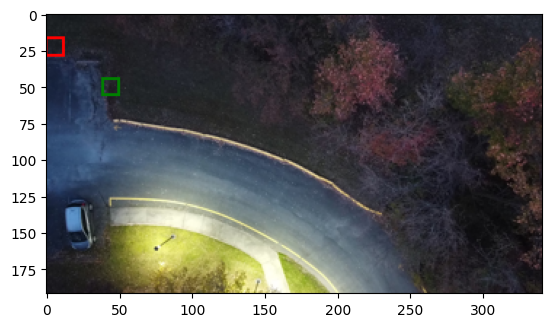

In [122]:
# Visualize the prediction on the randomly selected image
import matplotlib.pyplot as plt

# Assuming 'image_paths' contains the paths to your training images
random_image_path = image_paths[random_index]
img = Image.open(random_image_path).resize((341, 192))

# Draw the ground truth bounding box in red
draw = ImageDraw.Draw(img)
ground_truth_box = bounding_boxes[random_index]
draw.rectangle([ground_truth_box["x"], ground_truth_box["y"],
                ground_truth_box["x"] + ground_truth_box["width"],
                ground_truth_box["y"] + ground_truth_box["width"]], outline="red", width=2)

# Draw the predicted bounding box in green
draw.rectangle([predicted_x, predicted_y,
                predicted_x + predicted_width,
                predicted_y + predicted_width], outline="green", width=2)

# Display the image with bounding boxes
plt.imshow(img)
plt.show()